In [27]:
import pathlib

# Define data directory
train_dir = pathlib.Path('data/train')
test_dir = pathlib.Path('data/test')
train_masks_dir = pathlib.Path('masks/train')
test_masks_dir = pathlib.Path('masks/test')

In [28]:
import os
import cv2
import numpy as np

# check if the pixels are normalized
img = cv2.imread(os.path.join(test_dir, 'P1MF1_C.png'), cv2.IMREAD_GRAYSCALE)
print(np.max(img), np.min(img))
img_mask = cv2.imread(os.path.join(test_masks_dir, 'P1MF1_C.Png'), cv2.IMREAD_GRAYSCALE)
print(np.max(img_mask), np.min(img_mask))
print(img.shape, img_mask.shape)

255 0
255 0
(4096, 4096) (4096, 4096)


In [29]:
X_train = []
y_train = []
X_test = []
y_test = []

for img_path in train_dir.glob('*.png'):
    img = cv2.imread(str(img_path))
    img = cv2.resize(img, (256, 256))
    X_train.append(img)
    mask_path = os.path.join(train_masks_dir, img_path.stem + '.Png')
    img_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    img_mask = cv2.resize(img_mask, (256, 256))
    y_train.append(img_mask)

for img_path in test_dir.glob('*.png'):
    img = cv2.imread(str(img_path))
    img = cv2.resize(img, (256, 256))
    X_test.append(img)
    mask_path = os.path.join(test_masks_dir, img_path.stem + '.Png')
    img_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    img_mask = cv2.resize(img_mask, (256, 256))
    y_test.append(img_mask)

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# # Expand the dimensions of the images
#X_train = np.expand_dims(X_train, axis = 3)
y_train = np.expand_dims(y_train, axis = 3)
#X_test = np.expand_dims(X_test, axis = 3)
y_test = np.expand_dims(y_test, axis = 3)

print(X_train.shape, y_train.shape)

(50, 256, 256, 3) (50, 256, 256, 1)


In [30]:
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [31]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask = tf.round(tf.cast(input_mask, tf.float32) / 255.0)
    return input_image, input_mask

def load_image(input_image, input_mask):
    input_image = tf.image.resize(input_image, (128, 128))
    input_mask = tf.image.resize(input_mask,(128, 128), method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

In [32]:
TRAIN_LENGTH = len(X_train)
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [33]:
train_ds = train_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_ds = test_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

print("the shape of the train dataset is: ", train_ds)
# Show the labels of the first image
for image, mask in train_ds.take(1):
    print("the shape of the image is: ", image.numpy().shape)
    print("the shape of the mask is: ", mask.numpy().shape)
    print("the label of the first image is: ", mask.numpy())

the shape of the train dataset is:  <_ParallelMapDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(128, 128, 1), dtype=tf.float32, name=None))>
the shape of the image is:  (128, 128, 3)
the shape of the mask is:  (128, 128, 1)
the label of the first image is:  [[[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 ...

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]]


In [34]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

In [35]:
train_batches = (
    train_ds
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_ds.batch(BATCH_SIZE)

In [36]:
from matplotlib import pyplot as plt

def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

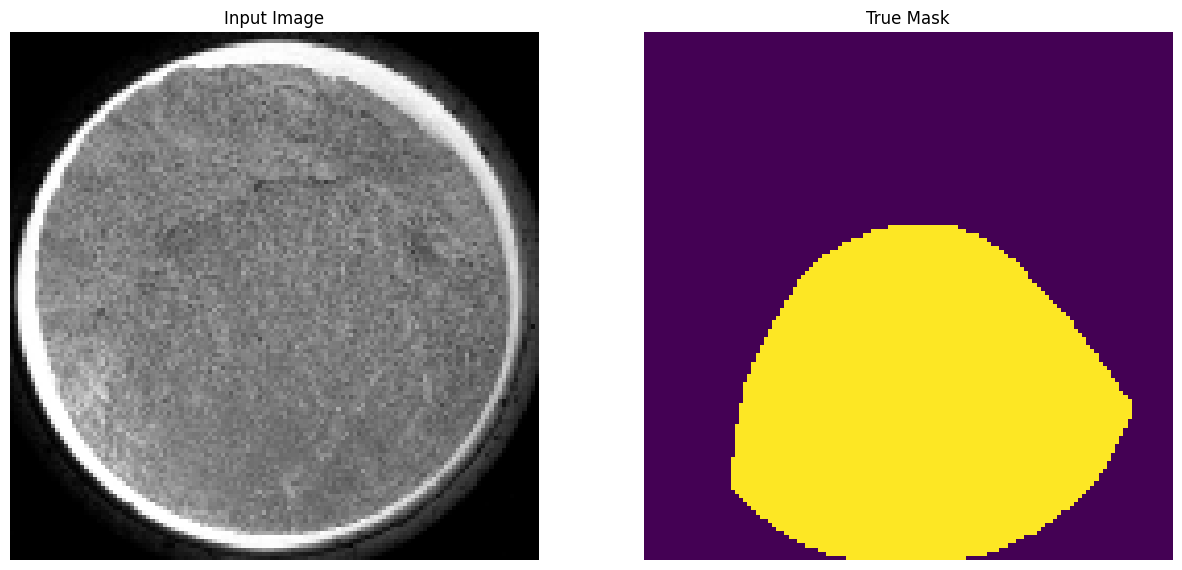

In [37]:
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

In [38]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [39]:
from tensorflow_examples.models.pix2pix import pix2pix

up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [40]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [41]:
OUTPUT_CLASSES = 2

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [42]:
# Try the model
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [43]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

2/2 [==============================] - 5s 985ms/step


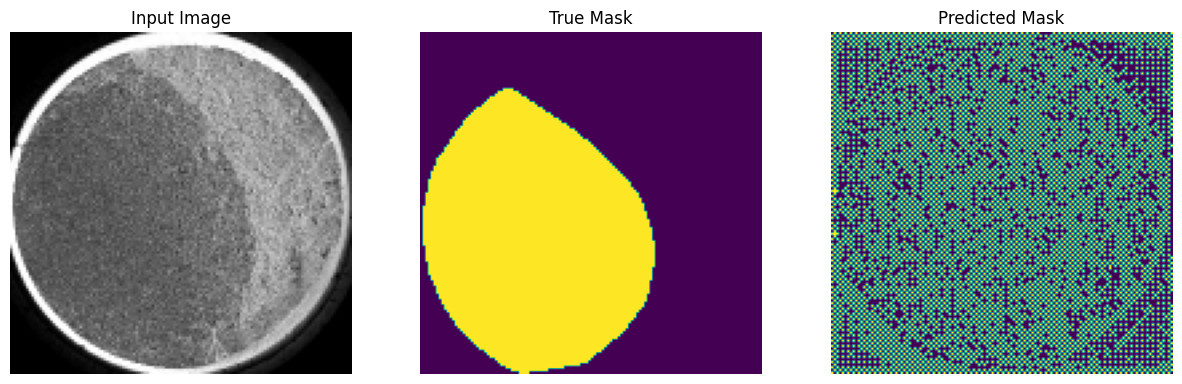

In [44]:
show_predictions(train_batches, 3)

In [45]:
from IPython.display import clear_output

class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    #clear_output(wait=True)
    show_predictions(train_batches, 1)
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

Epoch 1/20
2/2 [==============================] - 3s 2s/step


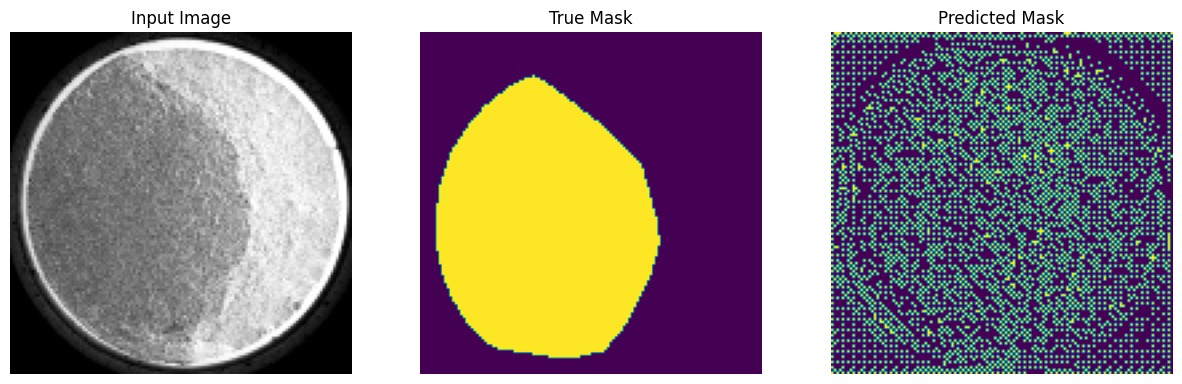


Sample Prediction after epoch 1

1/1 [==============================] - 25s 25s/step - loss: 0.8791 - accuracy: 0.5365
Epoch 2/20
2/2 [==============================] - 4s 2s/step


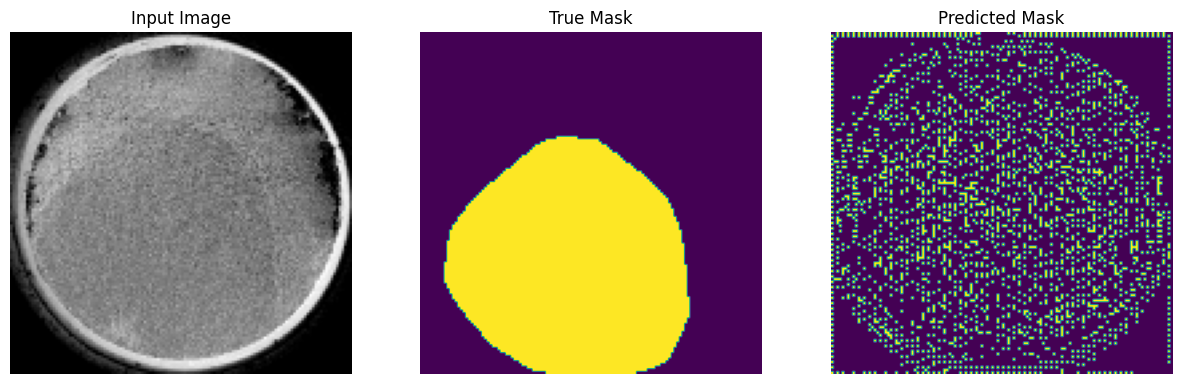


Sample Prediction after epoch 2

1/1 [==============================] - 8s 8s/step - loss: 0.6974 - accuracy: 0.5902
Epoch 3/20
2/2 [==============================] - 1s 542ms/step


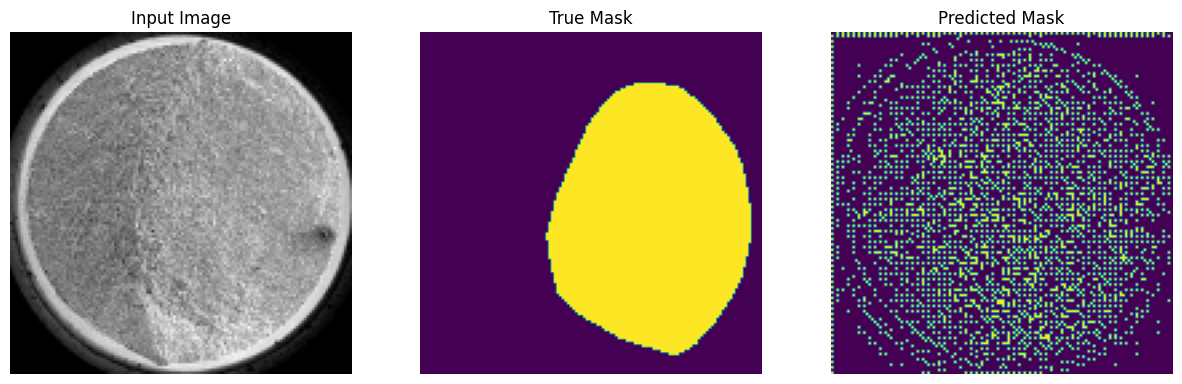


Sample Prediction after epoch 3

1/1 [==============================] - 5s 5s/step - loss: 0.6392 - accuracy: 0.6324
Epoch 4/20
2/2 [==============================] - 3s 2s/step


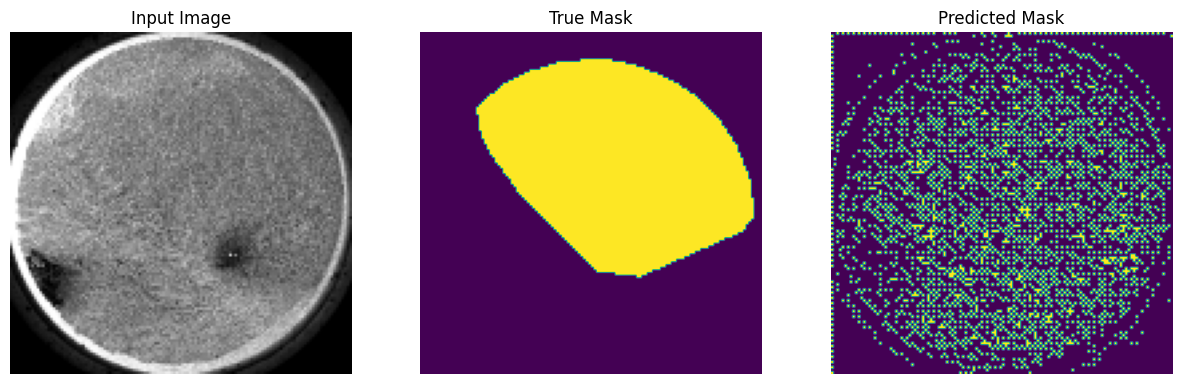


Sample Prediction after epoch 4

1/1 [==============================] - 8s 8s/step - loss: 0.6311 - accuracy: 0.6358
Epoch 5/20
2/2 [==============================] - 3s 1s/step


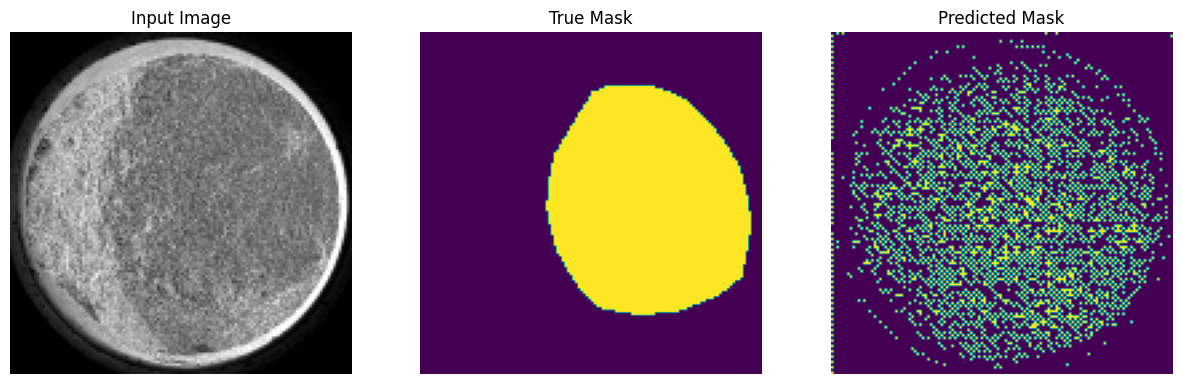


Sample Prediction after epoch 5

1/1 [==============================] - 10s 10s/step - loss: 0.6177 - accuracy: 0.6529
Epoch 6/20
2/2 [==============================] - 3s 922ms/step


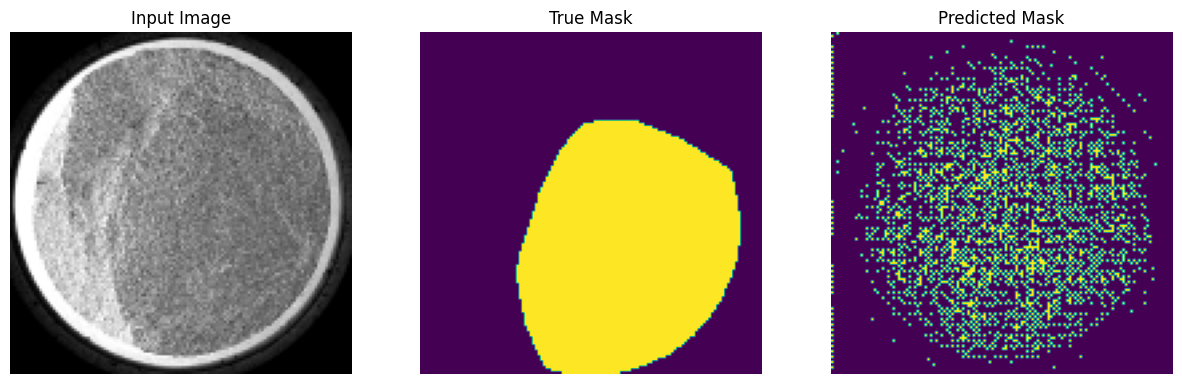


Sample Prediction after epoch 6

1/1 [==============================] - 10s 10s/step - loss: 0.5954 - accuracy: 0.6741
Epoch 7/20
2/2 [==============================] - 4s 1s/step


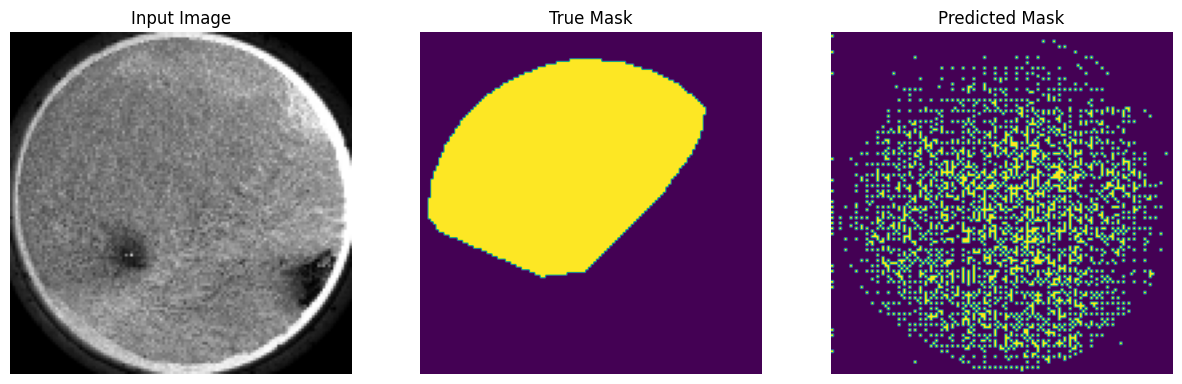


Sample Prediction after epoch 7

1/1 [==============================] - 9s 9s/step - loss: 0.5719 - accuracy: 0.6924
Epoch 8/20
2/2 [==============================] - 4s 2s/step


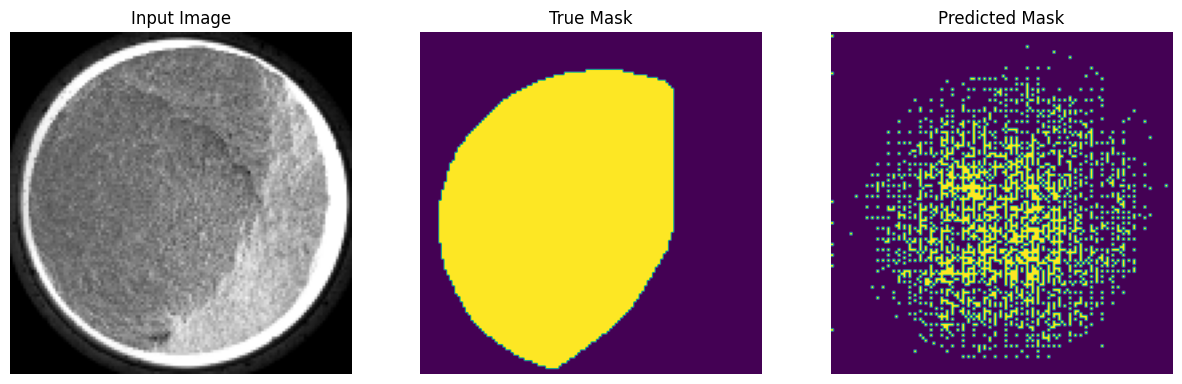


Sample Prediction after epoch 8

1/1 [==============================] - 10s 10s/step - loss: 0.5543 - accuracy: 0.7045
Epoch 9/20
2/2 [==============================] - 3s 2s/step


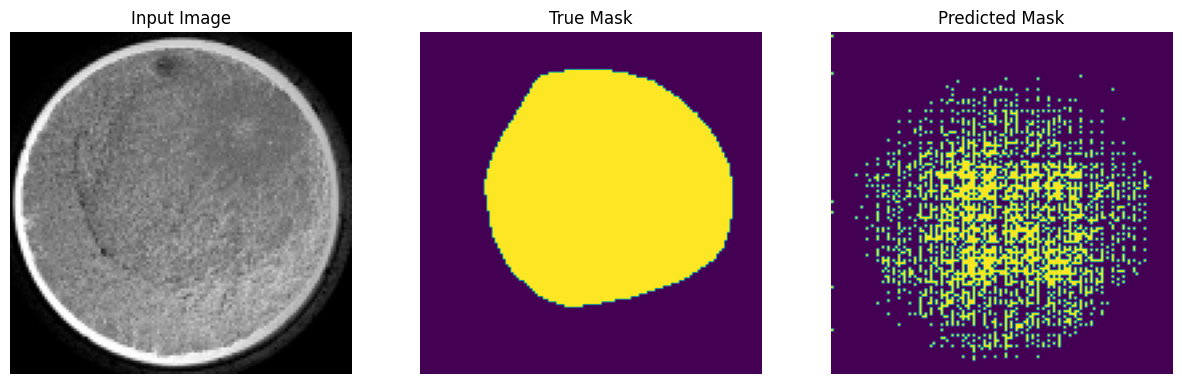


Sample Prediction after epoch 9

1/1 [==============================] - 8s 8s/step - loss: 0.5392 - accuracy: 0.7163
Epoch 10/20
2/2 [==============================] - 1s 505ms/step


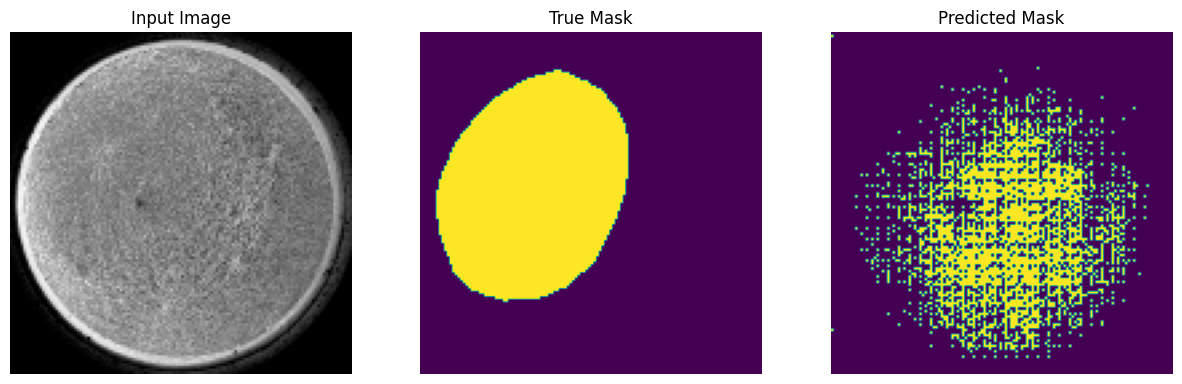


Sample Prediction after epoch 10

1/1 [==============================] - 5s 5s/step - loss: 0.5245 - accuracy: 0.7311
Epoch 11/20
2/2 [==============================] - 1s 463ms/step


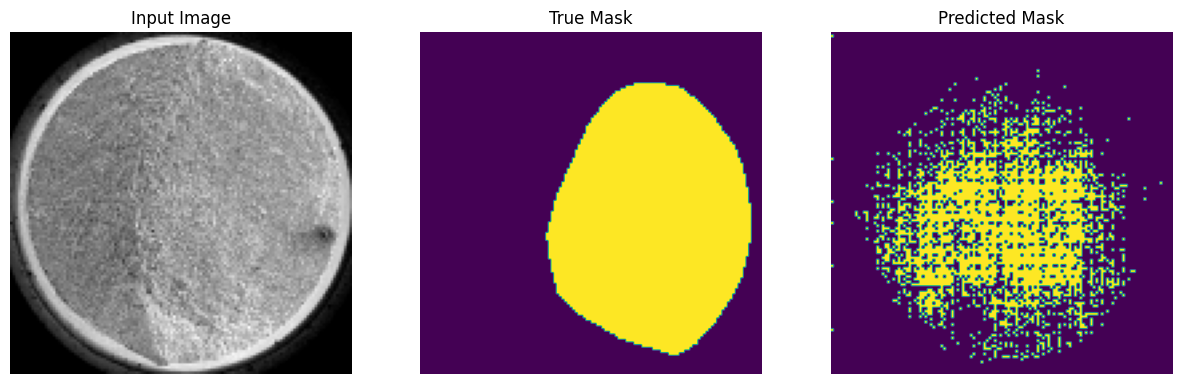


Sample Prediction after epoch 11

1/1 [==============================] - 6s 6s/step - loss: 0.5057 - accuracy: 0.7493
Epoch 12/20
2/2 [==============================] - 1s 517ms/step


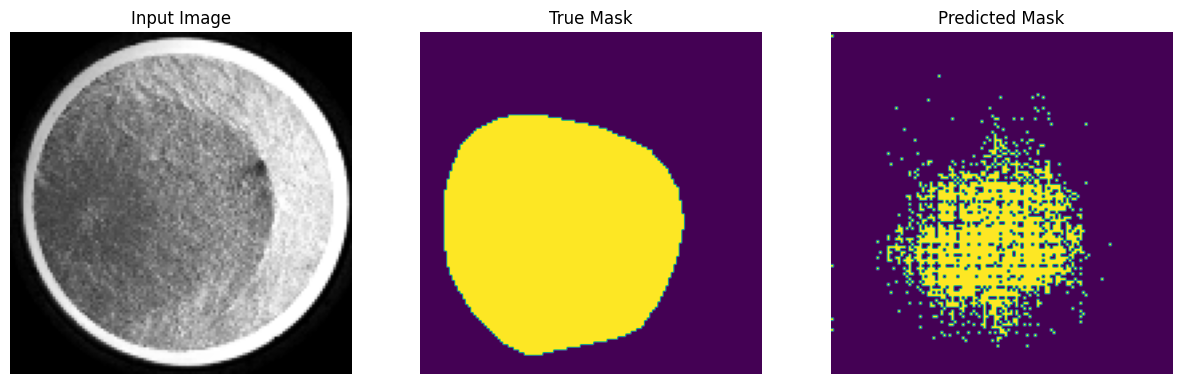


Sample Prediction after epoch 12

1/1 [==============================] - 4s 4s/step - loss: 0.4837 - accuracy: 0.7684
Epoch 13/20
2/2 [==============================] - 5s 2s/step


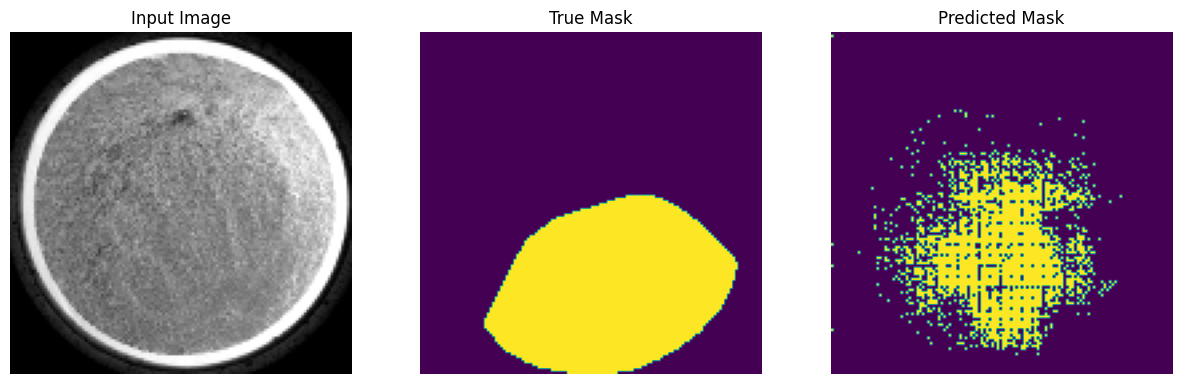


Sample Prediction after epoch 13

1/1 [==============================] - 9s 9s/step - loss: 0.4716 - accuracy: 0.7770
Epoch 14/20
2/2 [==============================] - 4s 1s/step


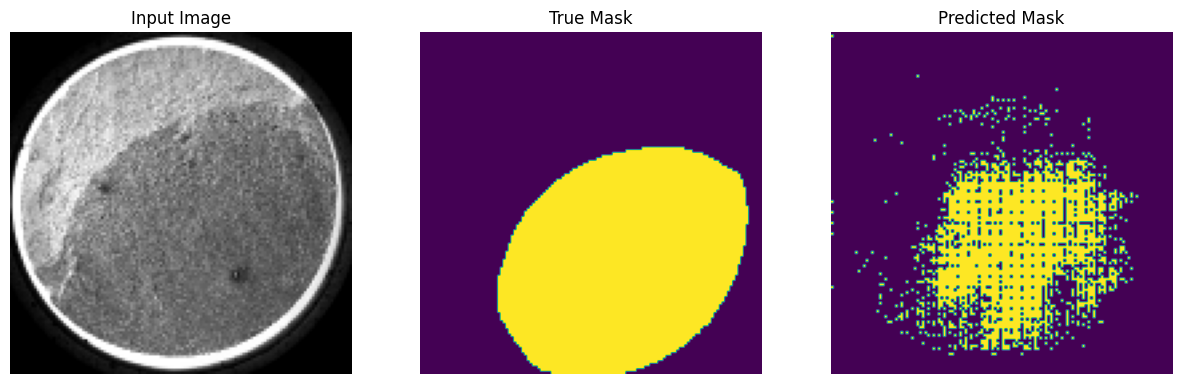


Sample Prediction after epoch 14

1/1 [==============================] - 11s 11s/step - loss: 0.4527 - accuracy: 0.7902
Epoch 15/20
2/2 [==============================] - 2s 468ms/step


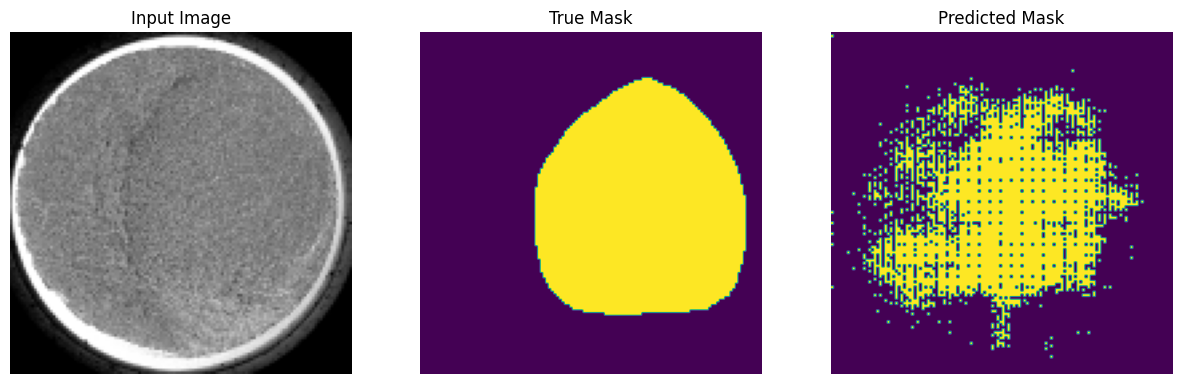


Sample Prediction after epoch 15

1/1 [==============================] - 5s 5s/step - loss: 0.4383 - accuracy: 0.7995
Epoch 16/20
2/2 [==============================] - 1s 505ms/step


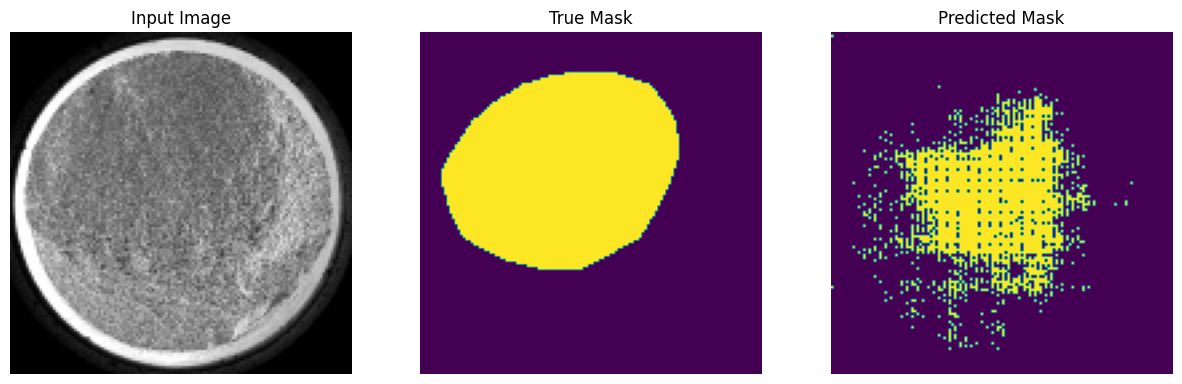


Sample Prediction after epoch 16

1/1 [==============================] - 5s 5s/step - loss: 0.4255 - accuracy: 0.8098
Epoch 17/20
2/2 [==============================] - 2s 698ms/step


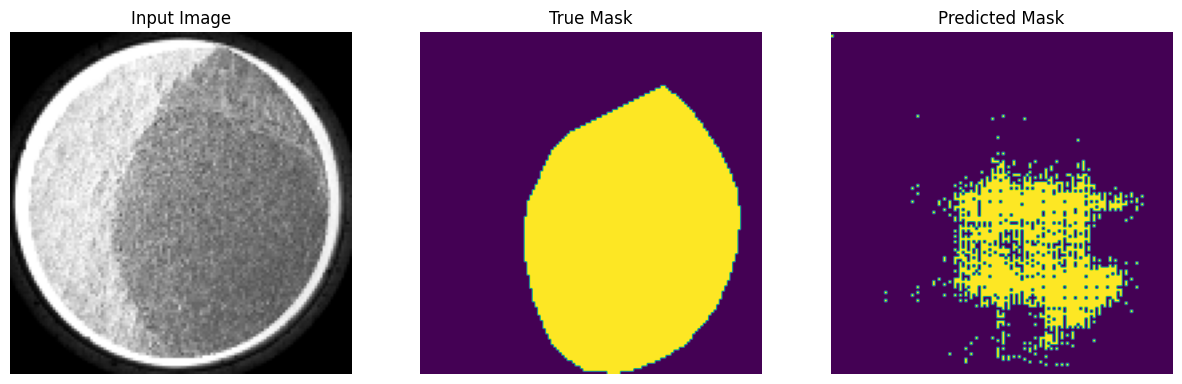


Sample Prediction after epoch 17

1/1 [==============================] - 7s 7s/step - loss: 0.4129 - accuracy: 0.8196
Epoch 18/20
2/2 [==============================] - 2s 762ms/step


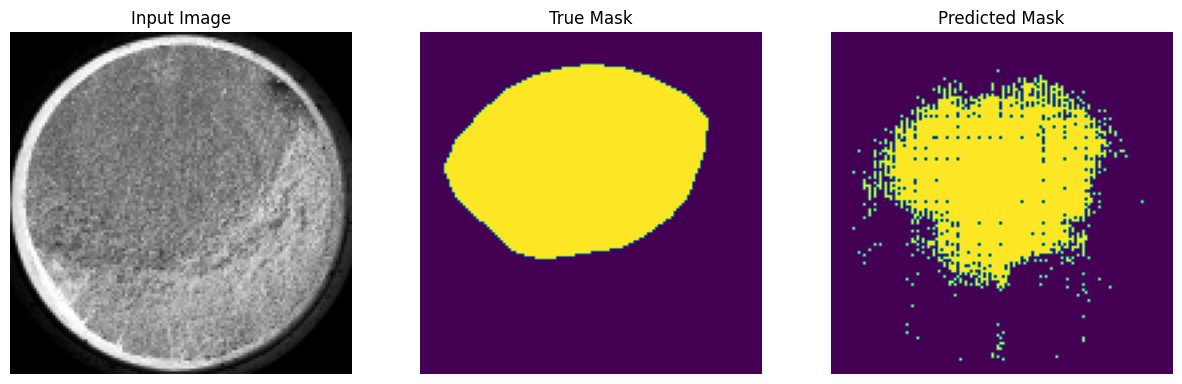


Sample Prediction after epoch 18

1/1 [==============================] - 7s 7s/step - loss: 0.3961 - accuracy: 0.8305
Epoch 19/20
2/2 [==============================] - 1s 517ms/step


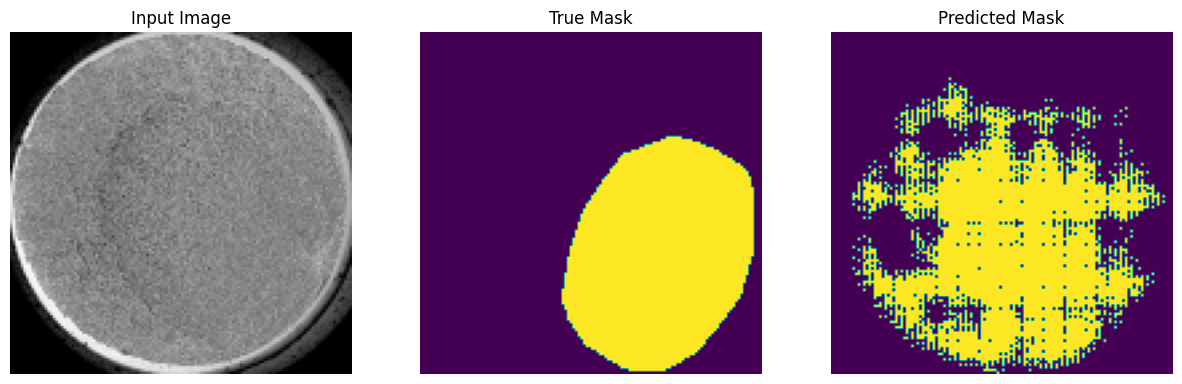


Sample Prediction after epoch 19

1/1 [==============================] - 5s 5s/step - loss: 0.3782 - accuracy: 0.8431
Epoch 20/20
2/2 [==============================] - 1s 449ms/step


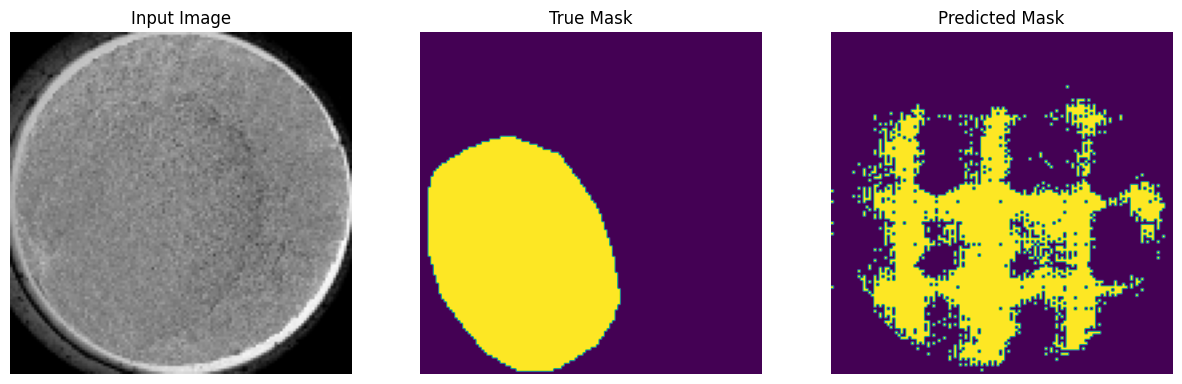


Sample Prediction after epoch 20

1/1 [==============================] - 4s 4s/step - loss: 0.3665 - accuracy: 0.8474


In [46]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = len(X_test)//BATCH_SIZE//VAL_SUBSPLITS
STEPS_PER_EPOCH = len(X_train)//BATCH_SIZE

model_history = model.fit(train_batches, epochs=EPOCHS,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback()])

In [47]:
# evaluate the model
model.evaluate(test_batches, verbose=1)

1/1 [==============================] - 3s 3s/step - loss: 0.5532 - accuracy: 0.7541


[0.5531947016716003, 0.754136323928833]